In [2]:
pip install mne mne-bids pandas numpy matplotlib pybv

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import mne  
import mne_bids  
from utils import resample, smooth_signal

In [4]:
bids_dir=r'/home/inesh_roy/Cogsci_Task/ds003688'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')

subject = '05'
acquisition = 'clinical'
task = 'film'
run = '1'
datatype = 'ieeg'
session = 'iemu'

In [5]:
channels_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='channels',
                                    extension='tsv',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    run = '1',
                                    root=bids_dir)
channels = pd.read_csv(str(channels_path.match()[0]), sep='\t', header=0, index_col=None)

In [6]:
data_path = mne_bids.BIDSPath(subject=subject,
                                    session=session,
                                    suffix='ieeg',
                                    extension='vhdr',
                                    datatype=datatype,
                                    task=task,
                                    acquisition=acquisition,
                                    root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]), scale=1.0, preload=False, verbose=True)
raw.set_channel_types({ch_name: str(x).lower()
                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                for ch_name, x in zip(raw.ch_names, channels['type'].values)})
raw.drop_channels([raw.ch_names[i] for i, j in enumerate(raw.get_channel_types()) if j == 'misc'])

Extracting parameters from /home/inesh_roy/Cogsci_Task/ds003688/sub-05/ses-iemu/ieeg/sub-05_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


/tmp/ipykernel_50074/2865297635.py:10: RuntimeWarning: The unit for channel(s) AH+, ECG+, EMG2, MKR1+, MKR2+, abdo+, emg1+, orb+, thor+, xxx1, xxx2, xxx3, xxx4, xxx5, xxx6, xxx7, xxx8 has changed from V to NA.
  raw.set_channel_types({ch_name: str(x).lower()


<RawBrainVision | sub-05_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 80 x 1083322 (529.0 s), ~69 KiB, data not loaded>

In [7]:

print("Channel Map:", list(zip(raw.ch_names, raw.get_channel_types()))[:102]) #makes tuples (Channel Name, Channel Type)

data_slice = raw.get_data()[0:5, :20]
print("\nFirst 20 Samples for first 5 Channels\n")
print(data_slice)

Channel Map: [('T01', 'ecog'), ('T02', 'ecog'), ('T03', 'ecog'), ('T04', 'ecog'), ('T05', 'ecog'), ('T06', 'ecog'), ('T07', 'ecog'), ('T08', 'ecog'), ('T09', 'ecog'), ('T10', 'ecog'), ('T11', 'ecog'), ('T12', 'ecog'), ('T13', 'ecog'), ('T14', 'ecog'), ('T15', 'ecog'), ('T16', 'ecog'), ('T17', 'ecog'), ('T18', 'ecog'), ('T19', 'ecog'), ('T20', 'ecog'), ('T21', 'ecog'), ('T22', 'ecog'), ('T23', 'ecog'), ('T24', 'ecog'), ('T25', 'ecog'), ('T26', 'ecog'), ('T27', 'ecog'), ('T28', 'ecog'), ('T29', 'ecog'), ('T30', 'ecog'), ('T31', 'ecog'), ('T32', 'ecog'), ('C33', 'ecog'), ('C34', 'ecog'), ('C35', 'ecog'), ('C36', 'ecog'), ('C37', 'ecog'), ('C38', 'ecog'), ('C39', 'ecog'), ('C40', 'ecog'), ('C41', 'ecog'), ('C42', 'ecog'), ('C43', 'ecog'), ('C44', 'ecog'), ('C45', 'ecog'), ('C46', 'ecog'), ('C47', 'ecog'), ('C48', 'ecog'), ('C49', 'ecog'), ('C50', 'ecog'), ('C51', 'ecog'), ('C52', 'ecog'), ('C53', 'ecog'), ('C54', 'ecog'), ('C55', 'ecog'), ('C56', 'ecog'), ('C57', 'ecog'), ('C58', 'ecog'), 

Reading 0 ... 1083321  =      0.000 ...   528.965 secs...


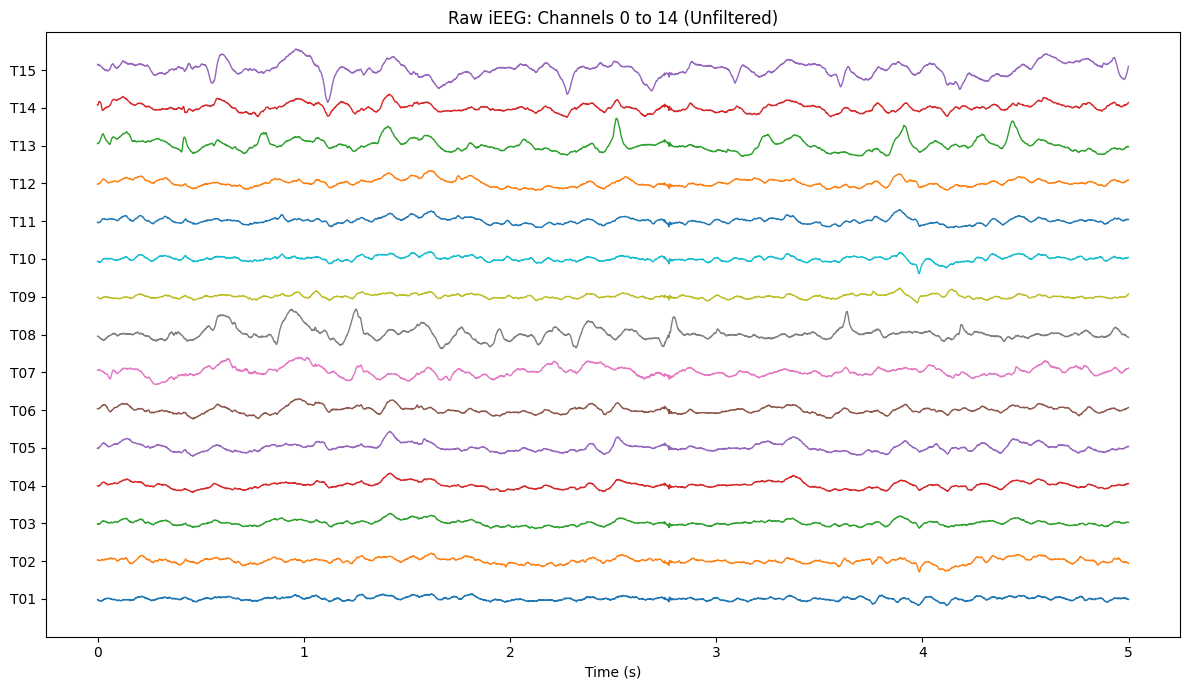

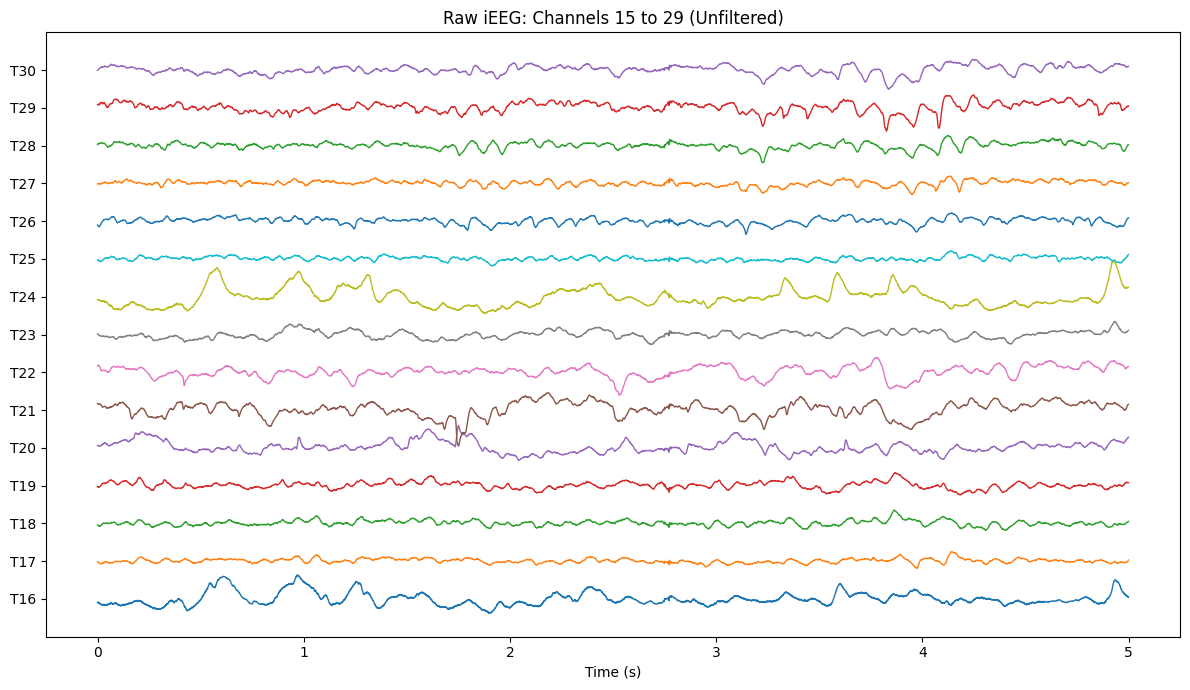

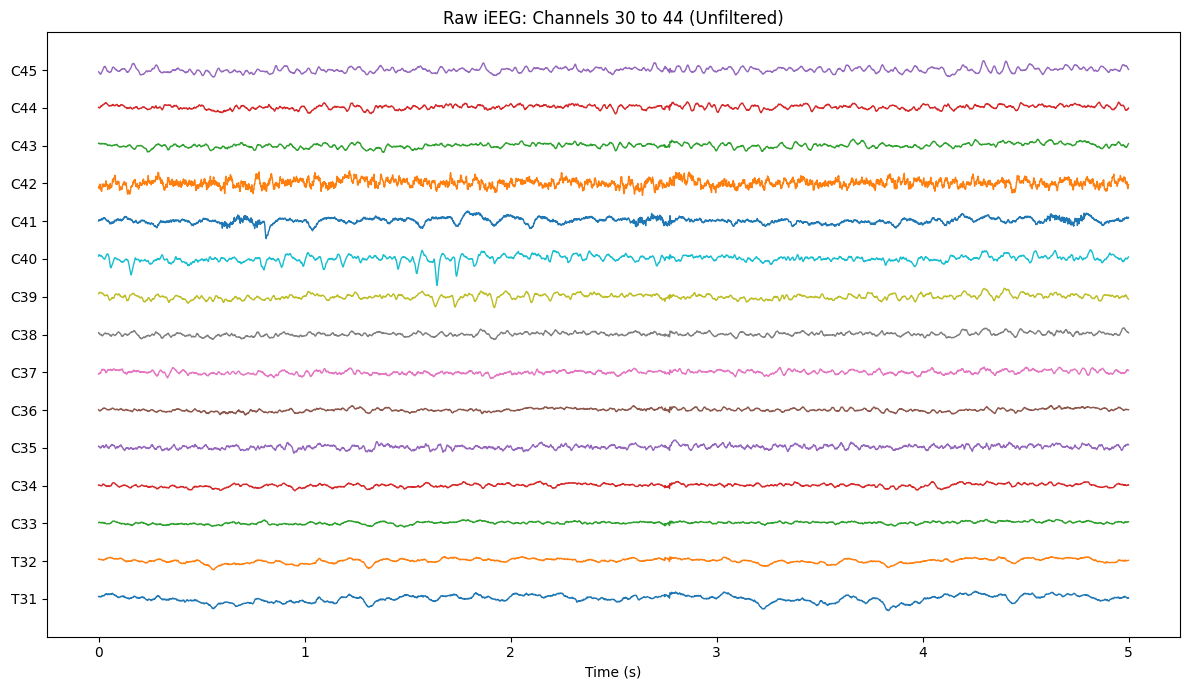

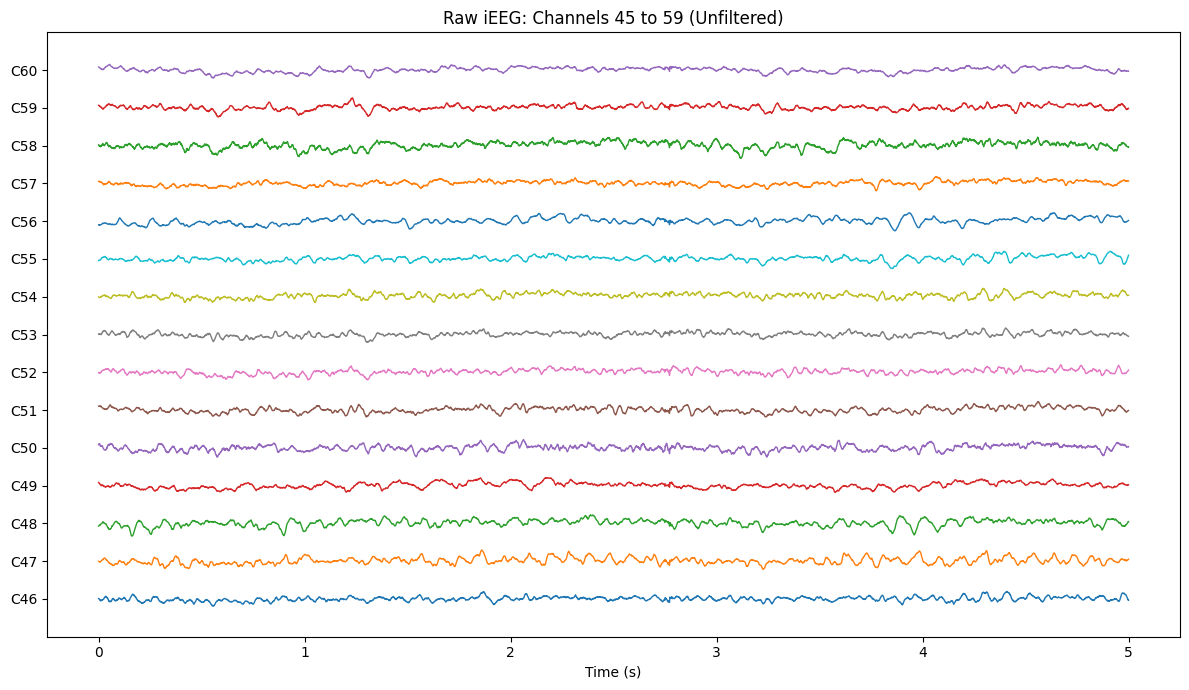

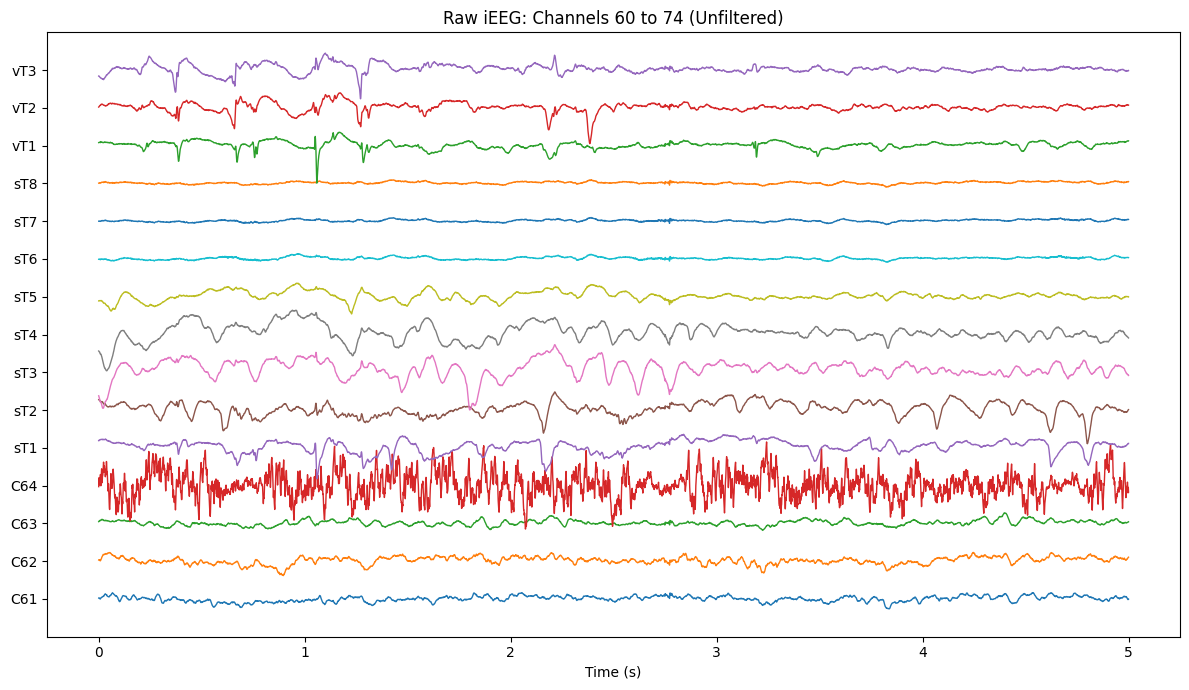

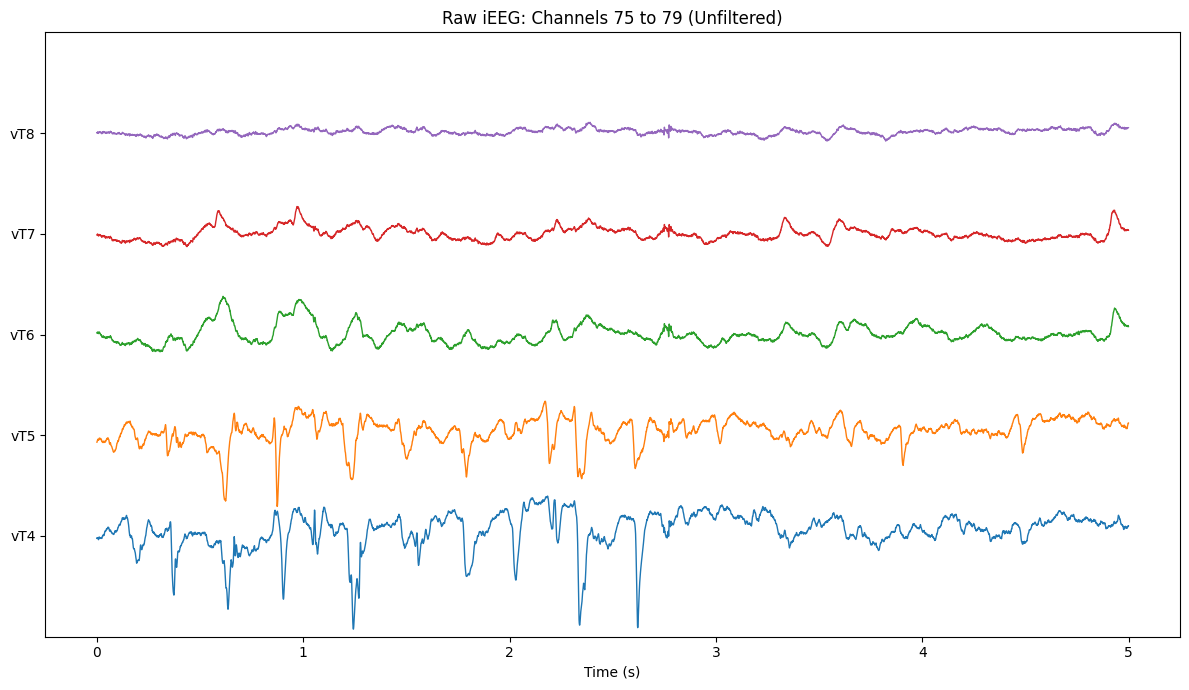

In [8]:

raw.load_data()
total_channels = len(raw.ch_names)
batch_size = 15
start_sec = 0
stop_sec = 5
offset = 0.0007  # Vertical spacing

#Looping through all channels
for start_ch in range(0, total_channels, batch_size):
    stop_ch = min(start_ch + batch_size, total_channels)
    n_channels_in_batch = stop_ch - start_ch
    
    data, times = raw[start_ch:stop_ch, int(start_sec * raw.info['sfreq']):int(stop_sec * raw.info['sfreq'])]
    
    # Creating necessary plots
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for i in range(n_channels_in_batch):
        ax.plot(times, data[i] + (i * offset), linewidth=1)
    
    ax.set_yticks([i * offset for i in range(n_channels_in_batch)])
    ax.set_yticklabels(raw.ch_names[start_ch:stop_ch])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Raw iEEG: Channels {start_ch} to {stop_ch-1} (Unfiltered)")
    ax.set_ylim(-offset, n_channels_in_batch * offset)
    
    plt.tight_layout()
    plt.show()  

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_50074/1878111500.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=255).plot()
/home/inesh_roy/Cogsci_Task/myenv/lib/python3.12/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


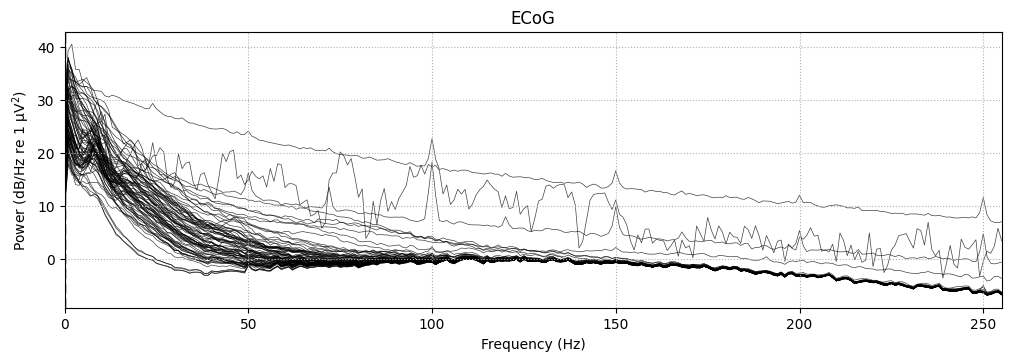

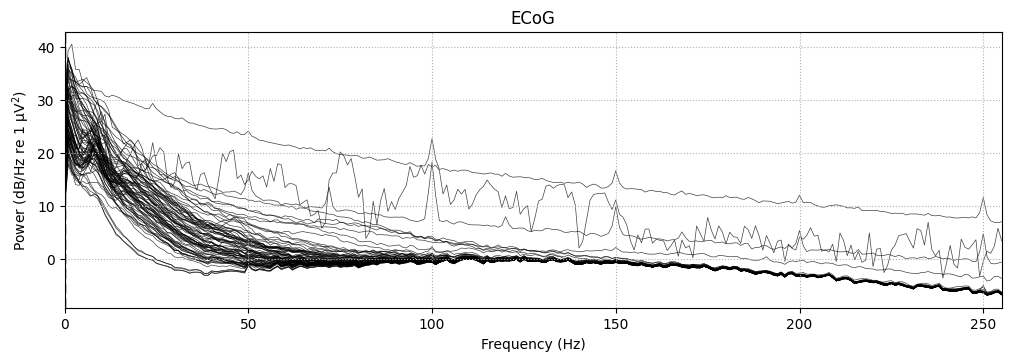

In [9]:
raw.compute_psd(fmax=255).plot()

In [10]:
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG'])) & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

<RawBrainVision | sub-05_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 73 x 1083322 (529.0 s), ~603.4 MiB, data loaded>

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_50074/1878111500.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=255).plot()
/home/inesh_roy/Cogsci_Task/myenv/lib/python3.12/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


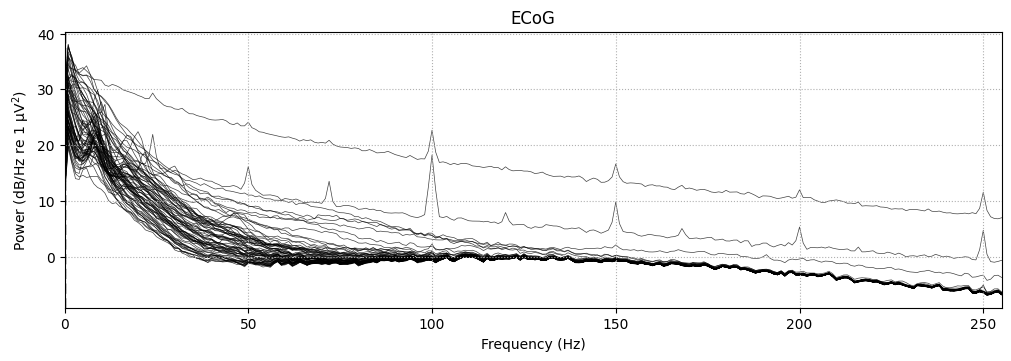

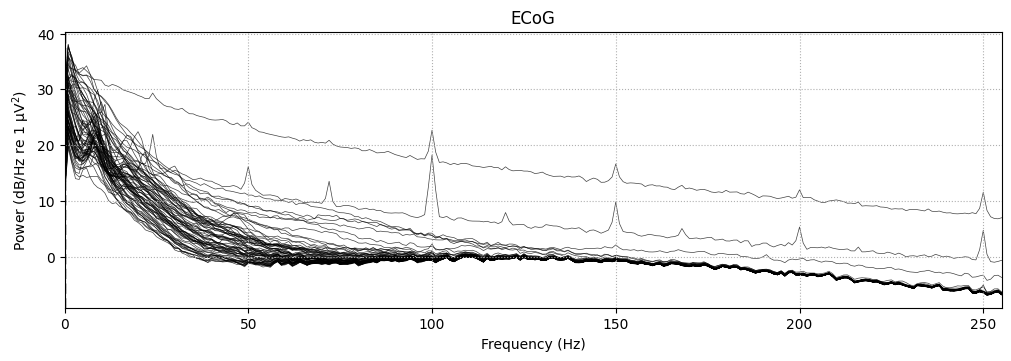

In [11]:
raw.compute_psd(fmax=255).plot()

In [12]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



<RawBrainVision | sub-05_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 73 x 1083322 (529.0 s), ~603.4 MiB, data loaded>

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_50074/1878111500.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=255).plot()
/home/inesh_roy/Cogsci_Task/myenv/lib/python3.12/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


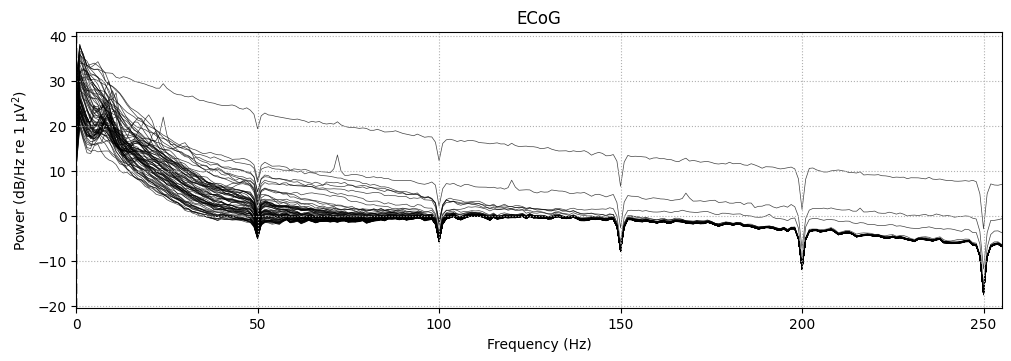

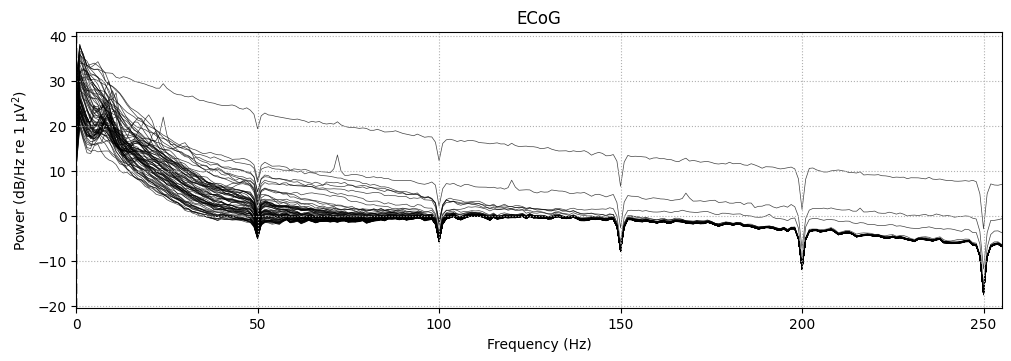

In [13]:
raw.compute_psd(fmax=255).plot()

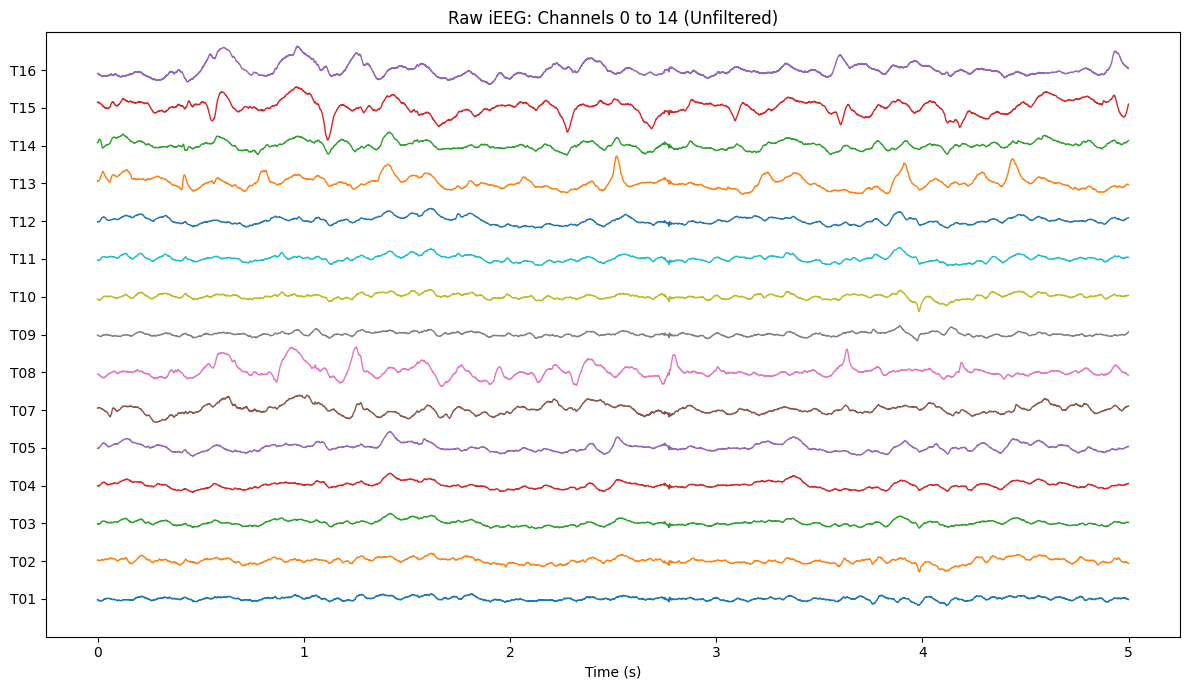

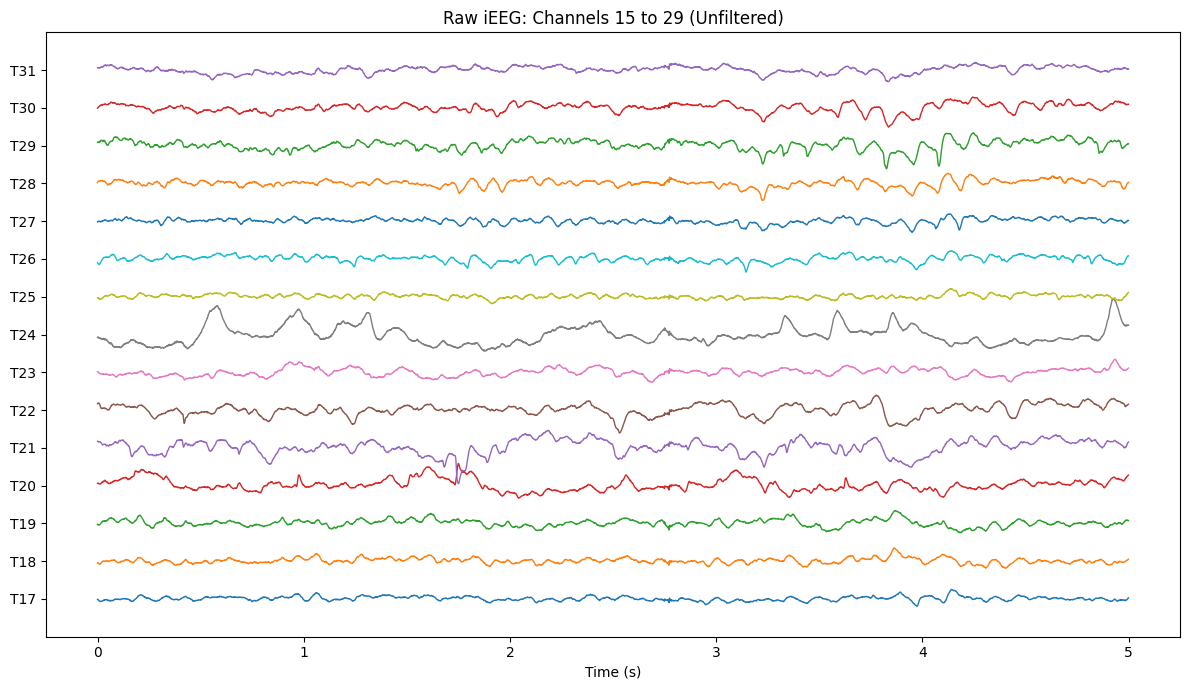

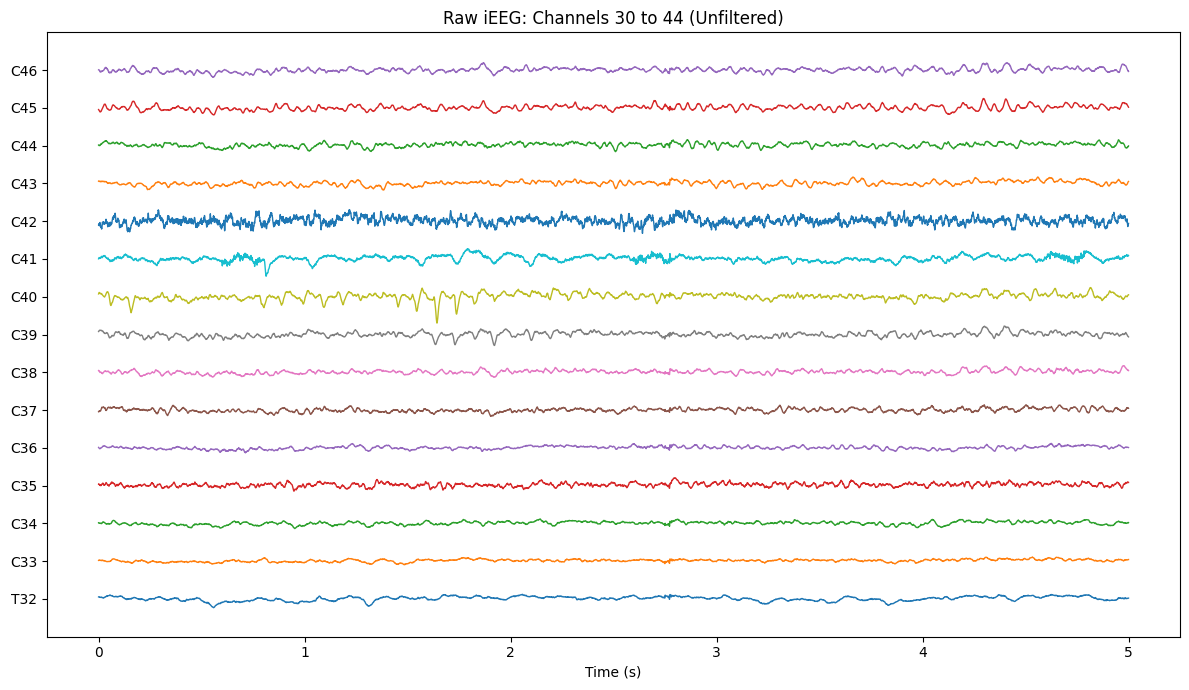

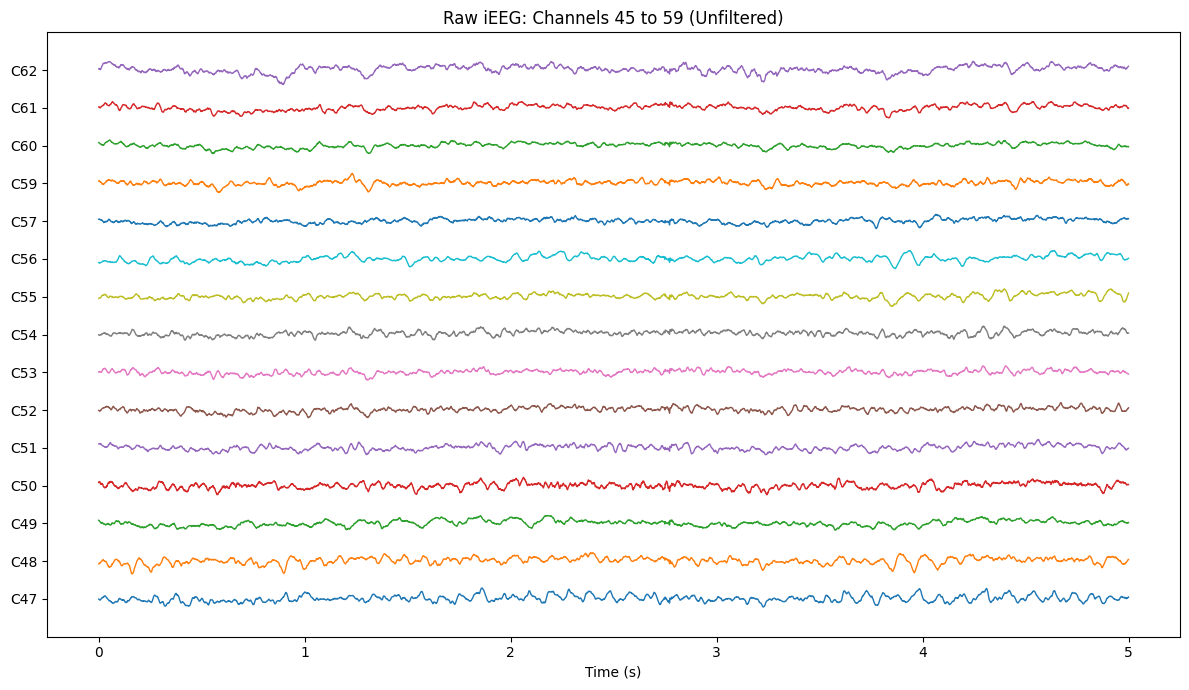

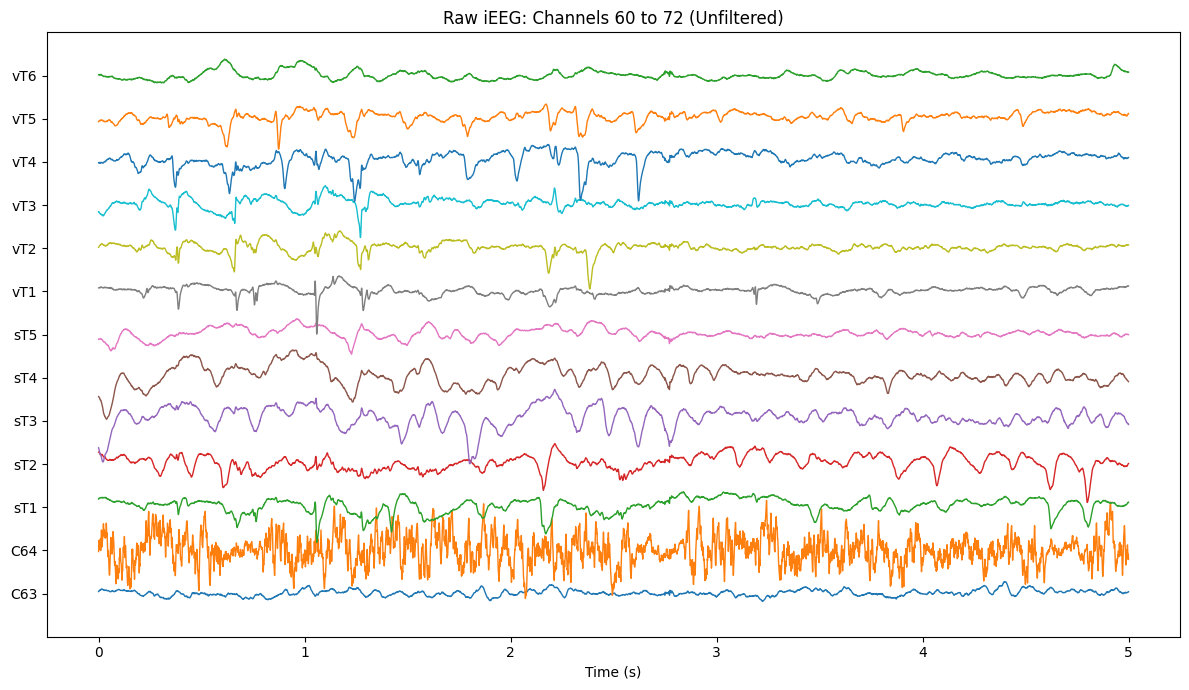

In [14]:

raw.load_data()
total_channels = len(raw.ch_names)
batch_size = 15
start_sec = 0
stop_sec = 5
offset = 0.0007  # Vertical spacing

#Looping through all channels
for start_ch in range(0, total_channels, batch_size):
    stop_ch = min(start_ch + batch_size, total_channels)
    n_channels_in_batch = stop_ch - start_ch
    
    data, times = raw[start_ch:stop_ch, int(start_sec * raw.info['sfreq']):int(stop_sec * raw.info['sfreq'])]
    
    # Creating necessary plots
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for i in range(n_channels_in_batch):
        ax.plot(times, data[i] + (i * offset), linewidth=1)
    
    ax.set_yticks([i * offset for i in range(n_channels_in_batch)])
    ax.set_yticklabels(raw.ch_names[start_ch:stop_ch])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Raw iEEG: Channels {start_ch} to {stop_ch-1} (Unfiltered)")
    ax.set_ylim(-offset, n_channels_in_batch * offset)
    
    plt.tight_layout()
    plt.show()  

In [ ]:


# 1. Identify Brain Channels (matching your TSV groupings T, sT, vT)
# We exclude MISC, TRIG, and ECG because they weren't part of the CAR
brain_picks = mne.pick_types(raw.info, ecog=True, seeg=True, eeg=True, exclude='bads')

# 2. Extract the raw data for the time window
t_start, t_stop = 0, 2
start_idx, stop_idx = raw.time_as_index([t_start, t_stop])
times = raw.times[start_idx:stop_idx]
data = raw.get_data(picks=brain_picks, start=start_idx, stop=stop_idx)

# 3. Perform the Manual CAR Calculation
# Calculate the mean across channels at every time point
global_mean = np.mean(data, axis=0)

# Subtract that mean from every channel
data_car = data - global_mean

# 4. Verification: Calculate the new average
# This MUST be zero because we just subtracted the mean
avg_before = global_mean
avg_after = np.mean(data_car, axis=0)

# 5. Plotting
plt.figure(figsize=(15, 6))
plt.plot(times, avg_before, label='Average Before CAR', color='red', alpha=0.5)
plt.plot(times, avg_after, label='Average After CAR (Perfect Zero)', color='blue', linestyle='--', linewidth=2)

plt.title("Manual CAR Verification: Mathematically Forced Zero")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Residual Average: {np.mean(avg_after):.2e}")